In [13]:
import sys
!{sys.executable} -m pip install sarpy pandas geopandas shapely numpy ipyleaflet

In [ ]:
from sarpy.io.complex.converter import open_complex
from sarpy.io.complex.sicd import SICDReader
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import requests
from shapely.geometry import Polygon, Point
from pathlib import Path

CACHE_DIR=Path('capella_open_data')
if not os.path.isdir(CACHE_DIR):
    os.mkdir(CACHE_DIR)

In [8]:
CATALOG_URL = 'https://capella-open-data.s3.us-west-2.amazonaws.com/stac/capella-open-data-by-product-type/capella-open-data-sicd/collection.json'
request = requests.get(CATALOG_URL)

catalog_json = request.json()
catalog_json['links'][5]
catalog = {}

In [10]:
from ipyleaflet import Map, basemaps, GeoData, Marker
from ipywidgets import HTML

map = Map(zoom=2, basemap=basemaps.OpenStreetMap.HOT, scroll_wheel_zoom=True)

def make_href(item_json):
    datetime = item_json['properties']['datetime']
    day = datetime.split('T')[0]
    datetime_parts = day.split('-')
    year = datetime_parts[0]
    month = '-'.join(datetime_parts[:2])
    return 'https://radiantearth.github.io/stac-browser/#/external/capella-open-data.s3.us-west-2.amazonaws.com/stac/capella-open-data-by-datetime/capella-open-data-{year}/capella-open-data-{month}/capella-open-data-{day}/{id}/{id}.json'.format(
        id=item_json['id'],
        month=month,
        year=year,
        day=day,
    )
    

geometries = gpd.GeoDataFrame(columns=['geometry', 'geometry.type'])
centroids = gpd.GeoDataFrame(columns=['geometry'])

for i, link in enumerate(catalog_json['links']):
    if not link['href'].startswith('../../capella-'):
        continue
    file_id = link['href'].split('/')[-1]
    filename = CACHE_DIR / file_id
    if os.path.exists(filename):
        # Load json from disk
        with open(filename, 'r') as json_file:
            item_json = json.load(json_file)
    else:
        # Request the json file from the server
        item_url = CATALOG_URL.replace('collection.json', link['href'])
        request = requests.get(item_url)
        with open(filename, 'w') as json_file:
            json_file.write(request.text)
        item_json = request.json()
    
    catalog[item_json['id']] = item_json

    # Add this item to the geometries layer
    geometries.loc[i] = Polygon(item_json['geometry']['coordinates'][0]), item_json['geometry']['type']
    
    # Add the marker to the map
    centroid = [item_json['properties']['proj:centroid']['lat'], item_json['properties']['proj:centroid']['lon']]
    marker = Marker(location=centroid, draggable=False)
    message = HTML()
    message.value = "<a href='{href}' target='_blank' rel='noopener noreferrer'>Details</a>".format(href=make_href(item_json))
    marker.popup = message
    map.add(marker)
                    

centroids = centroids.set_geometry('geometry')
geometries = geometries.set_geometry('geometry')

map.add(GeoData(geo_dataframe=geometries))

map

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [11]:
#reader = open_complex(os.path.expanduser("~/data/sar_capella/CAPELLA_C02_SM_SICD_HH_20201207083444_20201207083448.ntf"))

## Copy/Paste the ID from a Capella dataset here to visualise
CAPELLA_DATA_ID = 'CAPELLA_C06_SM_SICD_HH_20211119151326_20211119151331'

SAMPLE_URL = catalog[CAPELLA_DATA_ID]['assets']['HH']['href']
import smart_open
file_object = smart_open.open(
    SAMPLE_URL,
    mode='rb',
    buffering=4 * 1024 * 1024,
)
reader = SICDReader(file_object)

print('reader type = {}'.format(type(reader)))  # see the explicit reader type

print('image size (in pixels) = {}'.format(reader.data_size))

reader type = <class 'sarpy.io.complex.sicd.SICDReader'>
image size (in pixels) = (5074, 20101)


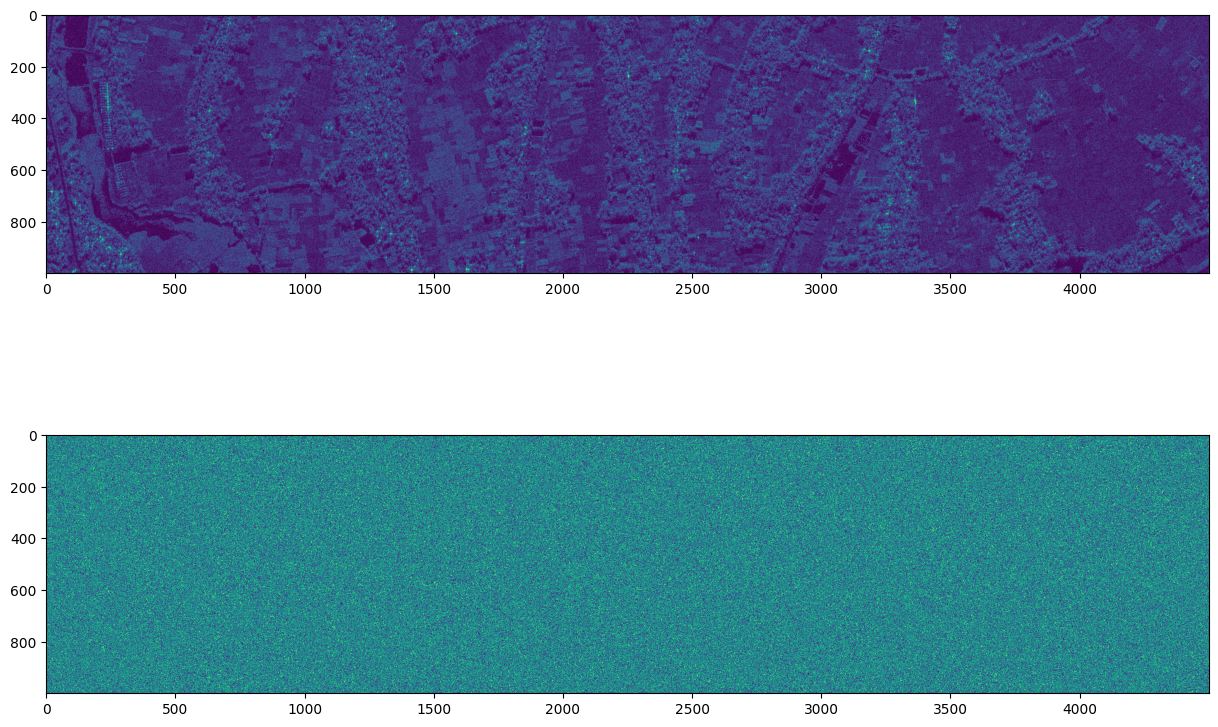

In [12]:
import matplotlib.pyplot as plt
from sarpy.visualization.remap import Density


remap_function = Density()
chip = reader[:1000, :4500]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axs[0].imshow(remap_function(np.absolute(chip)), cmap='viridis')
axs[1].imshow(remap_function(np.angle(chip)), cmap='viridis')
plt.show()